c:\Users\punna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


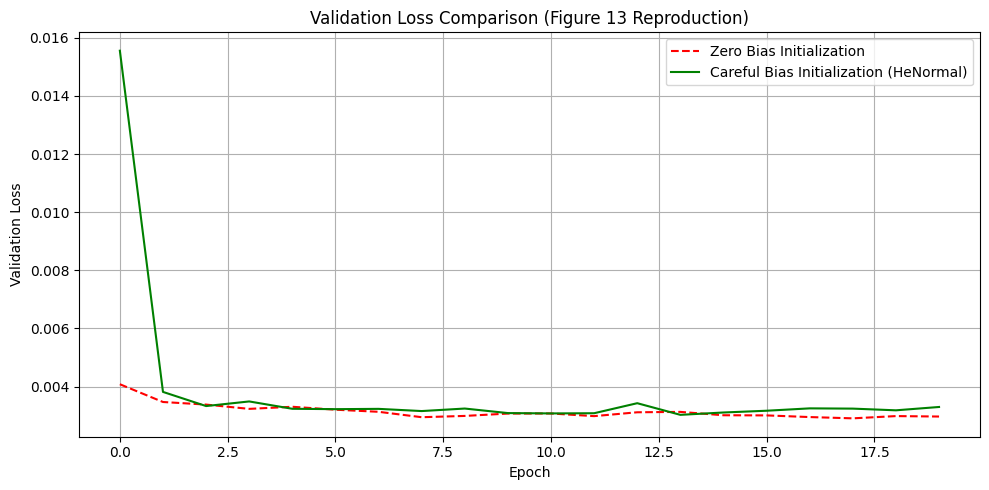

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Zeros, HeNormal
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load data
df = pd.read_csv("creditcard.csv")
X = df.drop(columns=['Class']).values
y = df['Class'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for Conv1D (samples, timesteps, features)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# --- Define function to build CNN with specified bias initializer ---
def build_cnn_model(bias_initializer):
    model = Sequential([
        Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1),
               bias_initializer=bias_initializer),
        BatchNormalization(),
        Dropout(0.2),

        Conv1D(filters=64, kernel_size=2, activation='relu', bias_initializer=bias_initializer),
        BatchNormalization(),
        Dropout(0.5),

        Flatten(),

        Dense(100, activation='relu', bias_initializer=bias_initializer),
        Dropout(0.5),
        Dense(50, activation='relu', bias_initializer=bias_initializer),
        Dense(25, activation='relu', bias_initializer=bias_initializer),

        Dense(1, activation='sigmoid', bias_initializer=bias_initializer)
    ])
    model.compile(optimizer=Adam(),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

# Build two models with different bias initializations
model_zero_bias = build_cnn_model(Zeros())
model_careful_bias = build_cnn_model(HeNormal())  # Common 'careful' initializer

# Train both models
history_zero_bias = model_zero_bias.fit(X_train, y_train, epochs=20, batch_size=2048, validation_data=(X_val, y_val), verbose=0)
history_careful_bias = model_careful_bias.fit(X_train, y_train, epochs=20, batch_size=2048, validation_data=(X_val, y_val), verbose=0)

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_zero_bias.history['val_loss'], label='Zero Bias Initialization', color='red', linestyle='--')
plt.plot(history_careful_bias.history['val_loss'], label='Careful Bias Initialization (HeNormal)', color='green')
plt.title("Validation Loss Comparison (Figure 13 Reproduction)")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
